# isogonal_hessian

> Study projection of cell-shape elasticity onto space of isogonal modes

In [ ]:
#| default_exp hessian

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Add methods to the HalfEdgeMesh class to compute isogonal modes

In [ ]:
#| export

@patch
def get_isogonal(self: msh.Vertex) -> Dict[int, NDArray[Shape["2"], Float]]:
    """
    Get isogonal mode for a given cell.
    
    Returns a dict: {faceid: translation vector} of primal vertices. Entries are
    
    j: T_j,bc / S_{self}bc
    
    where self,b,c are the three cells meeting at vertex j, and S is the area of the tension triangle.
    T_j is pointing towards vertex j (i.e. inwards)
    
    """

    # iterate over faces (cell vertices) adjacent to self. note: these are ccwise ordered by construction.
    isogonal_dict = {}
    for fc in self.faces:
        if fc is not None:
            S = fc.get_area()
            he = next(he for he in fc.hes if not self in he.vertices)            
            # note: hes are oriented ccwise
            T = dln.rot_mat(-np.pi/2)@(he.vertices[1].coords - he.vertices[0].coords)
            isogonal_dict[fc._fid] = T/S
        
    return isogonal_dict

In [ ]:
dln.rot_mat(np.pi/2) @ np.array([1,0])  # clockwise

In [ ]:
# testing this

mesh = dln.get_tri_hemesh()
mesh.set_voronoi()

v = mesh.vertices[30]
nghbs = v.faces
v, nghbs[0]

In [ ]:
# checking orientation conventions

#face = np.array([he.vertices[0].coords for he in nghbs[0].hes])
#plt.scatter(*face.T, c=np.arange(face.shape[0]))

cell = np.array([fc.primal_coords for fc in nghbs])
plt.scatter(*cell.T, c=np.arange(cell.shape[0]))

In [ ]:
iso_dict = v.get_isogonal()
iso_dict

In [ ]:
# isogonal dilation of single cell

colors = list(mpl.colors.BASE_COLORS.values())
for c, fc in zip(colors, nghbs):
    plt.scatter(*fc.primal_coords, color=c)
    plt.scatter(*(fc.primal_coords+.2*iso_dict[fc._fid]), color=c, marker='x')


In [ ]:
mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

%time iso_dicts = {key: val.get_isogonal() for key, val in mesh.vertices.items()}

# not super fast, but ok.

In [ ]:
#| export

@patch
def get_isogonal_transform_matrix(self: msh.HalfEdgeMesh, flattened=False) -> NDArray[Shape["*,*,2"], Float]:
    """
    Create a matrix that transforms isogonal modes to vertex displacement
    
    To do the basis conversion, order vertices (cells) and faces (cell vertices) according to their indices.
    
    If flattened, flatten by combining face & x/y-component index
    
    """    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    
    iso_matrix = np.zeros((len(self.vertices), len(self.faces), 2))
    iso_dicts = {key: val.get_isogonal() for key, val in self.vertices.items()}

    for vkey, iso_dict in iso_dicts.items():
        for fkey, dr in iso_dict.items():
            iso_matrix[vertex_key_dict[vkey], face_key_dict[fkey], :] = dr
    if flattened:
        return iso_matrix.reshape((iso_matrix.shape[0], iso_matrix.shape[1]*iso_matrix.shape[2]))
    return iso_matrix

In [ ]:
## testing

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()

iso_matrix = mesh.get_isogonal_transform_matrix()

iso_matrix.shape

(47, 70, 2)

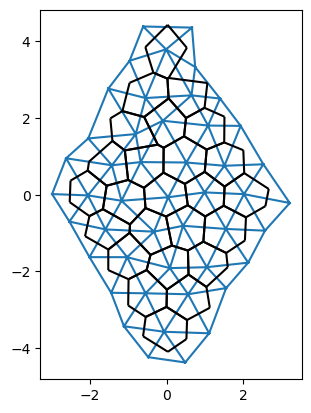

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
## test that isogonal modes don't affect the angle penalty

print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = np.einsum('i,ijk', theta, iso_matrix)
x0 = mesh.primal_vertices_to_vector(flattened=False)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr, axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 1.9351187319216423e-15
mean translation 0.19108270984812656
post 5.380140777333462e-15


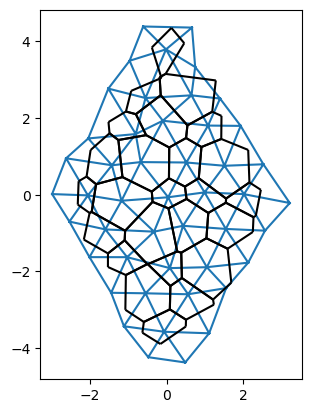

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
sorted(list(mesh.get_primal_edge_lens(oriented=True).values()))[:3] # some edge collapses = negative lengths

In [ ]:
#| export

def deflatten(x):
    return x.reshape((int(x.shape[0]/2),2))

In [ ]:
## check same thing but for "flattened" version to check everything works

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=True)


print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = theta @ iso_matrix
x0 = mesh.primal_vertices_to_vector(flattened=True)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=True)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(deflatten(dr), axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 6.250555628639626e-16
mean translation 0.2160714311366861
post 3.034239526300532e-15


In [ ]:
# comparing this to a random translation

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()
x0 = mesh.primal_vertices_to_vector(flattened=False)

dr_random = np.random.normal(size=(len(mesh.faces), 2), scale=.1)

new_positions = mesh.vector_to_primal_vertices(x0 + dr_random, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr_random, axis=1).mean())

print('post random', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

mean translation 0.12262856727344647
post random 0.5592749430409847


## Infer isogonal modes globally by comparing to Voronoi reference state and solving linear eqs.

In [ ]:
## test case: reference voronoi, plus isogonally transformed

mesh_ref = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh_ref.set_voronoi()

iso_matrix = mesh_ref.get_isogonal_transform_matrix(flattened=True)
theta = np.random.normal(scale=.1, size=len(mesh_ref.vertices))
theta -= theta.mean() # mean theta has no effect so normalize away

mesh_new = deepcopy(mesh_ref)
x0 = mesh_new.primal_vertices_to_vector(flattened=True)
new_positions = mesh.vector_to_primal_vertices(x0 + theta@iso_matrix, flattened=True)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]

In [ ]:
mesh_ref.triplot(); mesh_ref.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

Now infer the isogonal transform by solving for theta using least squares:
    
$$ \mathbf{x} =  \mathbf{x}_\text{Voronoi} + \text{Iso}^T \cdot \theta$$

where $\text{Iso}$ is the isogonal matrix of shape $(n_\text{cells}, n_\text{vertices})$

In [ ]:
x_new = mesh_new.primal_vertices_to_vector()
x_ref = mesh_ref.primal_vertices_to_vector()

theta_lstsq, _, _,  _ = np.linalg.lstsq(iso_matrix.T, x_new-x_ref, rcond=None)
theta_lstsq -= theta_lstsq.mean()

In [ ]:
mesh_infered = deepcopy(mesh_ref)
x0 = mesh_infered.primal_vertices_to_vector(flattened=True)
new_positions = mesh_infered.vector_to_primal_vertices(x0 + theta_lstsq@iso_matrix, flattened=True)
for key, val in mesh_infered.faces.items():
    val.primal_coords = new_positions[key]

In [ ]:
mesh_infered.triplot(); mesh_infered.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#| export

def get_isogonal_trafo(mesh: msh.HalfEdgeMesh, mesh_ref=None) -> Dict[int, float]:
    """
    Get isogonal trafo from mesh_ref->mesh, or, if mesh_ref is None, from isogonal reference to mesh.
    
    By convention, the sum of all isogonal modes is set to 0. Results are returned as a dict {vertex: theta}.
    """
    if mesh_ref is None:
        mesh_ref = deepcopy(mesh_ref)
        mesh_ref.set_voronoi()
    
    x = mesh.primal_vertices_to_vector()
    x_ref = mesh_ref.primal_vertices_to_vector()

    theta_lstsq = np.linalg.lstsq(iso_matrix.T, x-x_ref, rcond=None)[0]
    theta_lstsq -= theta_lstsq.mean()

    return mesh.vector_to_vertices(theta_lstsq)
    

## Getting the JAX hessian in the isogonal subspace

In [ ]:
#| export

get_E_hessian = jit(jax.hessian(iso.get_E))

## Testing 

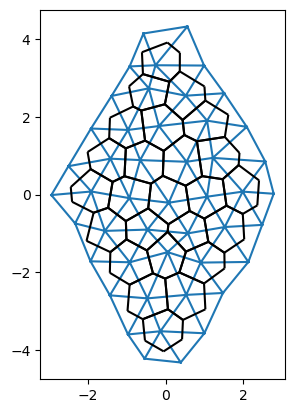

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1))
iso_matrix = mesh.get_isogonal_transform_matrix()

mesh.set_voronoi()

mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
x0 = mesh.primal_vertices_to_vector()
serialized_dict, _ = mesh.serialize_primal()

iso.get_E(x0, **serialized_dict, mod_area=1, angle_penalty=0)

Array(0.00610065, dtype=float64)

In [ ]:
# check 
areas = np.array([x for x in mesh.get_areas().values() if x is not None])
np.mean((areas -np.sqrt(3)/2)**2)

0.006100650877910924

In [ ]:
# now compute the hessian

hess = get_E_hessian(x0, **serialized_dict, mod_area=1, angle_penalty=0)

hess.shape, iso_matrix.shape

((140, 140), (47, 70, 2))

In [ ]:
# a,b,c =  cells. i,j,k = spatial components (x/y). f,g,h = faces

iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

projected_hess = iso_matrix_flat @ hess @ iso_matrix_flat.T

projected_hess.shape

(47, 47)

## Diagonlization, direct & dense

Compute the Hessian -> multiply with matrices to project onto isogonal modes -> diagonalize

Do all of it using direct diag & dense matrices. Later, for large systems, it might be appropriate to use indirect computation of the Jacobian/vector product, sparse matrices to represent the isogonal modes, and iterative diagonalization (e.g. Lanzos).

In [ ]:
## triangular lattice with voronoi

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.15, nx=15, ny=15))  #(7,13)  -(15, 19), (9,9)
mesh.transform_vertices(dln.shear_mat(1.05))

iso_matrix = mesh.get_isogonal_transform_matrix(flattened=False)
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)
serialized_dict, _ = mesh.serialize_primal()

mesh.set_voronoi()

for v in mesh.vertices.values():
    v.rest_shape = np.sqrt(3)*np.eye(2)

In [ ]:
mod_shear = 0.5

energy_args={'mod_area': 0, 'mod_perimeter': 0,
             'mod_bulk': 1, 'mod_shear': mod_shear,
             'angle_penalty': 1000}

sol = mesh.optimize_cell_shape(energy_args=energy_args, tol=1e-5, maxiter=100000, return_sol=True)

minimal_l = .01
flipped, failed_flip = mesh.intercalate(exclude=[], minimal_l=minimal_l, reoptimize=True,
                                        optimizer_args={"energy_args": energy_args})
print(flipped)
sol['fun']

[]


0.06382392887602874

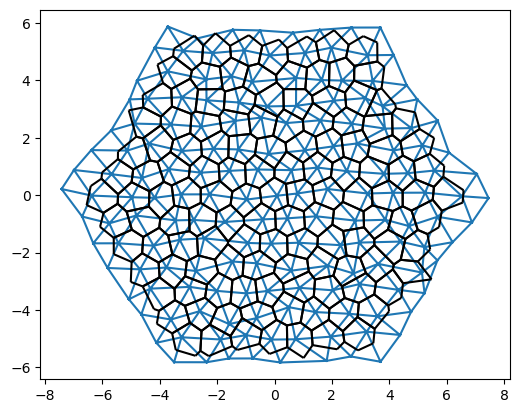

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
%%time

x0 = mesh.primal_vertices_to_vector()

hess = get_E_hessian(x0, **serialized_dict,
                     mod_bulk=1, mod_shear=mod_shear,
                     mod_area=0, mod_perimeter=0)
projected = iso_matrix_flat @ hess @ iso_matrix_flat.T
vals, vecs = np.linalg.eigh(projected)

CPU times: user 3.21 s, sys: 482 ms, total: 3.69 s
Wall time: 2.81 s


In [ ]:
E = iso.get_E(x0, **serialized_dict, mod_bulk=1, mod_shear=mod_shear, mod_area=0, mod_perimeter=0 ,angle_penalty=0)

E # .14 if not optimized. so we are certainly not at a minimum!

Array(2.69183847, dtype=float64)

In [ ]:
# hessian eigenvalues vs shear modulu
# 0     : 0.01 1e-3
# 0.125 : 0.38 1e-3
# 0.25  : 0.7 1e-3
# 0.5   : 1.4 1e-3
# 1     : 2.8 1e-3

In [ ]:
vals.shape, vals[:6]

((169,),
 array([-1.82707447e-15,  5.51669489e-15,  1.27415735e-14,  1.40167937e-03,
         1.51907428e-03,  5.03822175e-03]))

[<matplotlib.lines.Line2D>]

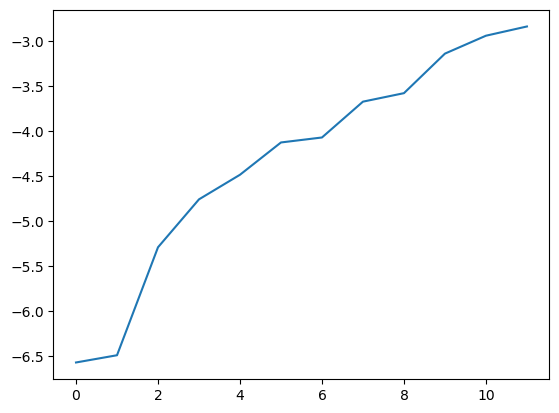

In [ ]:
plt.plot(np.log(vals[3:15]))

<matplotlib.collections.PathCollection>

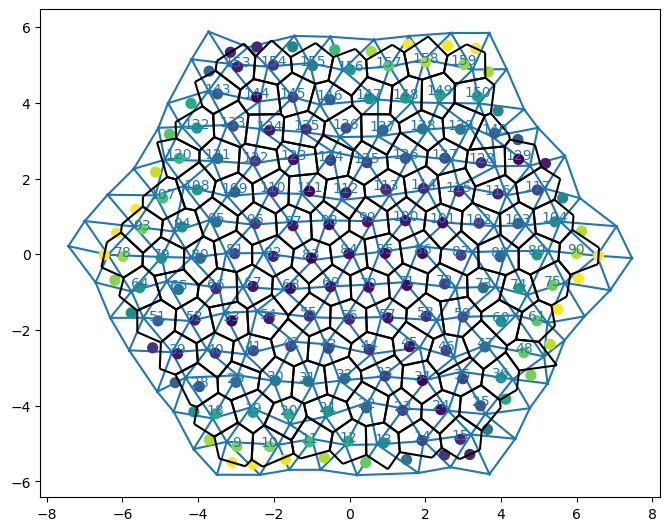

In [ ]:
## spatial plot of magnitudes

n_eigen = 3

fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

# now calculate the energies and centroids

iso_mode = mesh.vector_to_vertices(np.abs(vecs[:, n_eigen]), flattened=False)

for_scttr = np.stack([np.hstack([mesh.vertices[key].get_centroid(), [val]])
                      for key, val in iso_mode.items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.15, s=50)

# 0 = linear gradient i.e. translation. 3 = quadratic i.e. shear

## Apply a trafo based on the lowest eigenvec and see whether energy changes

In [ ]:
vals[20], vals.shape

(0.0968441575165303, (169,))

In [ ]:
mesh_new = deepcopy(mesh)

n_eigen = 3
magnitude = 10

theta = magnitude * vecs[:, n_eigen] # 0, 1, 2 = translation. 3, 4 = shear. then come a bunch localized at the bdry,
dr = theta @ iso_matrix_flat
x0 = mesh_new.primal_vertices_to_vector()

new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]


In [ ]:
np.linalg.norm(deflatten(dr), axis=1).mean() # .035 -> .039

0.67473697124296

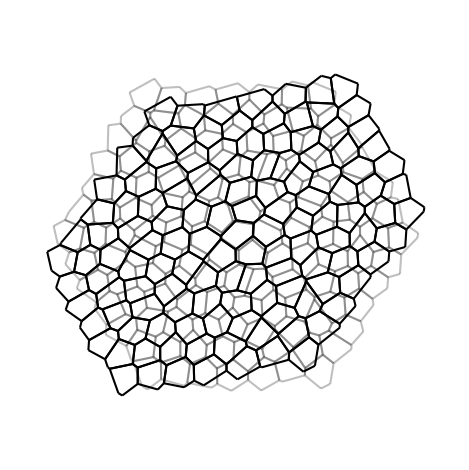

In [ ]:
mesh.cellplot(alpha=.25)
mesh_new.cellplot()
#mesh_new.triplot()
#mesh_new.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

lim = 8
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")

plt.tight_layout()
#plt.savefig("plots/SI figs and movies/isogonal_hessian_shear_mode_2.pdf")

# mode 30 - lowest non-edge mode - is a radial shear.

# multipole shear expansion?

# for shape energy, it looks more like localization at pairs of cells. 

In [ ]:
x0_pre = mesh.primal_vertices_to_vector()
x0_post = mesh_new.primal_vertices_to_vector()

serialized_dict, _ = mesh_new.serialize_primal()


print('pre iso', iso.get_E(x0_pre, **serialized_dict, mod_bulk=1, mod_shear=1, mod_area=0, mod_perimeter=0))
print('post iso', iso.get_E(x0_post, **serialized_dict, mod_bulk=1, mod_shear=1, mod_area=0, mod_perimeter=0))

# .03 -> .06 for lowest mode
# .03 -> .12 for highest mode

# looks like the isogonal modes work roughly as expected.
# the null modes increase energy less than the highest modes.

# presumably we should evaluate this around the minimum.

# as expected, lowest eigenvector is a translation!

pre iso 0.10848937345663795
post iso 0.25057516129718405


## measure shear modulus

Plot displacement vs energy

In [ ]:
n_eigen = 3


displacement = []
energy = []
magnitudes = np.linspace(-3.2, 3.4, 50)
shear = []

x0_pre = mesh.primal_vertices_to_vector()

keys = sorted(mesh.vertices.keys())
centroids_pre = np.stack([mesh.vertices[k].get_centroid() for k in keys])

for magnitude in tqdm(magnitudes):

    mesh_new = deepcopy(mesh)

    theta = magnitude * vecs[:, n_eigen]
    dr = theta @ iso_matrix_flat
    x0 = mesh_new.primal_vertices_to_vector()

    new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
    for key, val in mesh_new.faces.items():
        val.primal_coords = new_positions[key]

    x0_post = mesh_new.primal_vertices_to_vector()
    serialized_dict, _ = mesh_new.serialize_primal()

    displacement.append(np.sign(magnitude) * np.linalg.norm(deflatten(dr), axis=1).mean())
    energy.append(iso.get_E(x0_post, **serialized_dict, mod_bulk=1, mod_shear=mod_shear,
                            mod_area=0, mod_perimeter=0))

    centroids_post = np.stack([mesh_new.vertices[k].get_centroid() for k in keys])
    matrix = np.linalg.lstsq(centroids_pre, centroids_post, rcond=None)[0]
    vals = np.linalg.eigvals(matrix)
    shear.append(vals[0] / vals[1]-1)
    
energy = np.array(energy)
energy -= energy.min()
shear = np.array(shear)

mean_length = np.mean(list(mesh.get_edge_lens().values()))
displacement = np.array(displacement) / mean_length

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
shear.min(), shear.max()

(-0.10192958958333187, 0.10644082930735399)

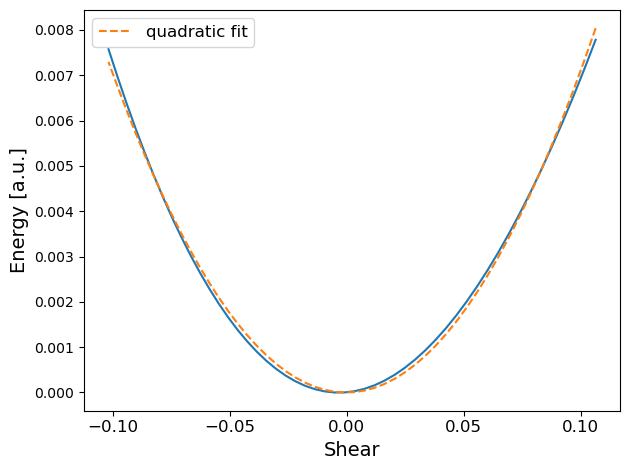

In [ ]:
plt.plot(shear, energy)

poly = np.polyfit(shear, energy, deg=2,)
plt.plot(shear, np.polyval(poly, shear), ls='--', label='quadratic fit')
plt.legend(fontsize=12)

plt.xticks([-.1, -.05, 0, .05, .1], fontsize=12)
plt.xlabel("Shear", fontsize=14)
plt.ylabel("Energy [a.u.]", fontsize=14)
plt.tight_layout()

plt.savefig("plots/SI figs and movies/shear_vs_energy_mod_0.5.pdf")

In [ ]:
poly[0]/2 # .72 for shear modulus 1, .36 for shear modulus 0.5. As expected.

0.0035353248561485156

In [ ]:
shear_vs_curvature = [[1, .72],
                      [.5, .37],
                      [.25, .19],
                      [.125, .1],
                      [0, 0]]

shear_vs_curvature = np.array(shear_vs_curvature)

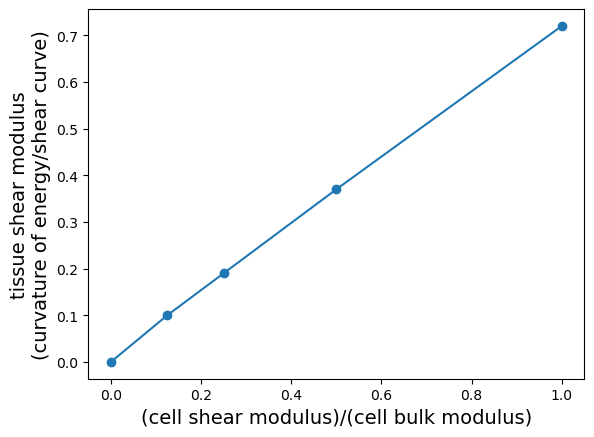

In [ ]:
plt.plot(*shear_vs_curvature.T, marker="o")
plt.xlabel("(cell shear modulus)/(cell bulk modulus)", fontsize=14)
plt.ylabel("tissue shear modulus\n(curvature of energy/shear curve)", fontsize=14)
plt.savefig("plots/SI figs and movies/tissue_shear_vs_cell_shear.pdf")